In [1]:
import pickle
from typing import Optional
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from gurobipy import GRB
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from plots import *
from ems_data import *
from simulation import *
from dataset import *
from linear_model import *
from neural_network import *
from mip_models import *

TRAINING_METRICS = ['coverage_9min', 'coverage_15min', 'survival_rate', 'response_time_mean', 'response_time_median', 'response_time_90th_percentile']
FACILITY_CAPACITY = 4
TIME_LIMIT = 60  # Just for testing

def plot_metric(X: np.ndarray, y: np.ndarray, metric: str, metric_short: Optional[str] = None):
    """Plot histogram and box plots side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(metric)
    if metric_short is not None:
        metric = metric_short
    ax[0].hist(y, bins=100)
    ax[0].set_xlabel(metric)
    ax[0].set_ylabel("Frequency")
    plot_metric_by_ambulance_count(X, y, metric, ax=ax[1])
    return fig, ax

print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

In [2]:
N_AMBULANCES = 17  # 14, 17, 20

region_id = 3
with open('ems_data.pkl', 'rb') as f:
    ems_data = pickle.load(f)
ems_data.region_id = region_id
n_stations = len(ems_data.stations)
print(f"# stations: {n_stations}")
sim = Simulation(ems_data, n_days=100, n_replications=5)

dataset = pd.read_csv(f'dataset{region_id}.csv')
X = dataset.drop(columns=METRICS).to_numpy()
Y = dataset[METRICS].to_numpy()

# for metric in METRICS:
#     y = Y[:, METRICS.index(metric)]
#     plot_metric(X, y, metric)

# stations: 17


In [3]:
# Estimate busy_fraction and service_rate
BUSY_FRACTION = {}
SERVICE_RATE = {}
for n_ambulances in [14, 17, 20]:
    # Busy fraction used by MEXCLP so estimate using best w.r.t. coverage_15min
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'coverage_15min')
    BUSY_FRACTION[n_ambulances] = y['busy_fraction']
    # Service rate used by p-median + queueing model so estimate using best w.r.t. response_time_mean
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'response_time_mean')
    SERVICE_RATE[n_ambulances] = y['service_rate']
print(f"BUSY_FRACTION = {BUSY_FRACTION}\nSERVICE_RATE = {SERVICE_RATE}")

BUSY_FRACTION = {14: 0.288004162638955, 17: 0.2288075320373579, 20: 0.1880189046214391}
SERVICE_RATE = {14: 19.377337143021244, 17: 20.266597902930563, 20: 20.77655572881174}


# Cov9

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Coverage (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Coverage (transformed)'>],
       dtype=object))

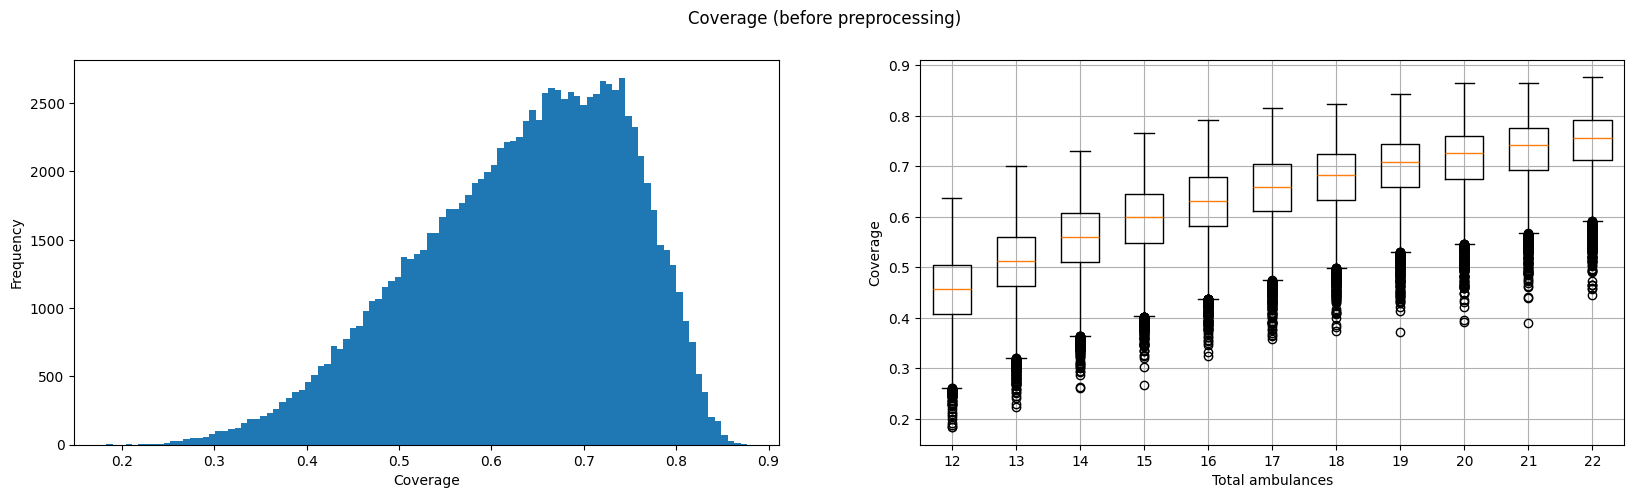

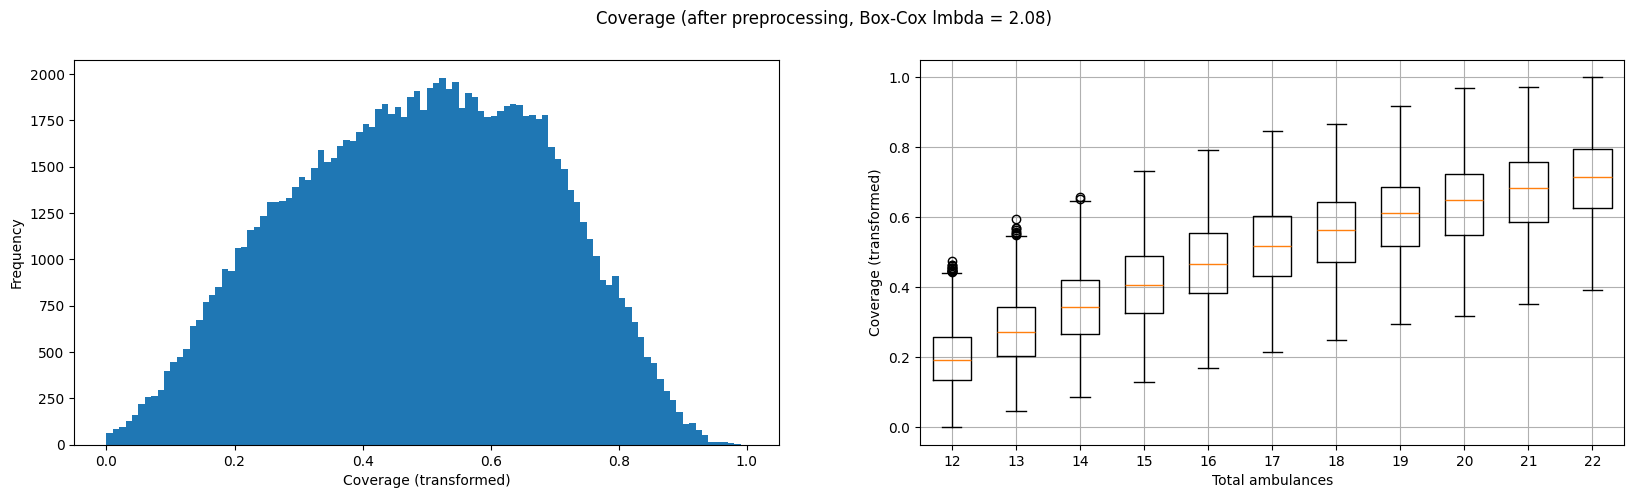

In [4]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.coverage_15min.to_numpy()
plot_metric(X, y, "Coverage (before preprocessing)", "Coverage")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Coverage (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Coverage (transformed)")

In [5]:
X_new = binarize_solutions(X)
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge.fit(X_new, y)
with open('trained_ml_models/simcoe_coverage_linear.pkl', 'wb') as f:
    pickle.dump(ridge, f)

In [6]:
with open('trained_ml_models/simcoe_coverage_linear.pkl', 'rb') as f:
    ridge = pickle.load(f)
solution, model = linear_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    coef=keep_relevant_coefficients(ridge.coef_, n_stations, FACILITY_CAPACITY),
    intercept=ridge.intercept_,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-17
Set parameter TimeLimit to value 60
(68,) (17, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 53 rows, 69 columns and 239 nonzeros
Model fingerprint: 0x7551bb4c
Variable types: 1 continuous, 68 integer (68 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 2e+01]
Found heuristic solution: objective -0.6749981
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 52 rows, 68 columns, 170 nonzeros
Variable types: 0 continuous, 68 integer (68 binary)
Found heuristic solution: objective 0.5643103

Root relaxation: objective 9.163203e-01, 1 iterations, 0.00 seconds (0.00 work units)

    

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.509888,0.774657,0.056269,9.499717,6.879226,19.677475,0.234367,19.924081
1,0.509214,0.774853,0.055870,9.499287,6.897577,19.786762,0.234075,20.029715
2,0.497817,0.780911,0.055722,9.367389,6.965136,19.335963,0.234328,20.112216
3,0.504983,0.777920,0.055866,9.452842,6.842002,19.448363,0.231007,19.919901
4,0.504256,0.771948,0.055610,9.540893,6.891094,19.820818,0.234288,19.752284


In [7]:
model = DecisionTreeRegressor()
grid_search = GridSearchCV(model, {'min_samples_split': [80, 90, 100, 110, 120]}, cv=5)
grid_search.fit(X, y)
dt = grid_search.best_estimator_
with open('trained_ml_models/simcoe_coverage_dt.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [8]:
with open('trained_ml_models/simcoe_coverage_dt.pkl', 'rb') as f:
    dt = pickle.load(f)
solution, model = dt_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    dt=dt,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 7952 rows, 5319 columns and 21219 nonzeros
Model fingerprint: 0x26d74258
Variable types: 2652 continuous, 2667 integer (2650 binary)
Coefficient statistics:
  Matrix range     [2e-02, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [4e+00, 2e+01]
Found heuristic solution: objective 0.0220303
Presolve removed 1780 rows and 1725 columns
Presolve time: 0.17s
Presolved: 6172 rows, 3594 columns, 34136 nonzeros
Variable types: 0 continuous, 3594 integer (3577 binary)
Found heuristic solution: objective 0.1059322

Root relaxation: objective 9.415692e-01, 1721 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.466206,0.738568,0.051396,10.153042,7.399417,21.026533,0.238557,19.619509
1,0.476215,0.755336,0.053408,9.844888,7.240668,20.432019,0.231074,19.796414
2,0.462163,0.741285,0.051456,10.110610,7.520953,20.588894,0.234003,19.818767
3,0.470927,0.753458,0.052364,9.873159,7.345879,19.977474,0.232794,19.724354
4,0.468346,0.738668,0.052221,10.119015,7.380504,20.894620,0.236497,19.642746


In [5]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='simcoe_coverage'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 81%|████████  | 81/100 [02:35<00:36,  1.92s/epoch, best_val_loss=0.00015, train_loss=0.000695, val_loss=0.000338] 


Early stopping


 32%|███▏      | 32/100 [01:01<02:10,  1.91s/epoch, best_val_loss=4.21e-5, train_loss=4.3e-5, val_loss=4.91e-5]  


Early stopping


100%|██████████| 100/100 [02:46<00:00,  1.66s/epoch, best_val_loss=3.26e-5, train_loss=3.18e-5, val_loss=3.26e-5]


In [9]:
weights, biases = MLP.load_npz('trained_ml_models/simcoe_coverage.npz')
solution, model = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4038 rows, 3036 columns and 26072 nonzeros
Model fingerprint: 0x293d470d
Variable types: 2019 continuous, 1017 integer (1000 binary)
Coefficient statistics:
  Matrix range     [2e-06, 7e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 64 rows and 45 columns
Presolve time: 0.05s
Presolved: 3974 rows, 2991 columns, 26212 nonzeros
Variable types: 1983 continuous, 1008 integer (991 binary)

Root relaxation: objective 2.701637e+00, 1486 iterations, 0.12 seconds (0.27 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.701

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.556861,0.837291,0.060560,8.187566,6.302414,15.750379,0.226010,20.828738
1,0.540734,0.837194,0.060170,8.287480,6.382550,15.751791,0.217557,20.767351
2,0.544877,0.830028,0.059729,8.321807,6.457243,16.095167,0.222468,20.792919
3,0.550355,0.834348,0.060533,8.215657,6.351320,15.884193,0.223143,20.775384
4,0.546235,0.838243,0.060261,8.217164,6.449833,15.918921,0.221224,20.753596


# SurvRate

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Survival rate (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Survival rate (transformed)'>],
       dtype=object))

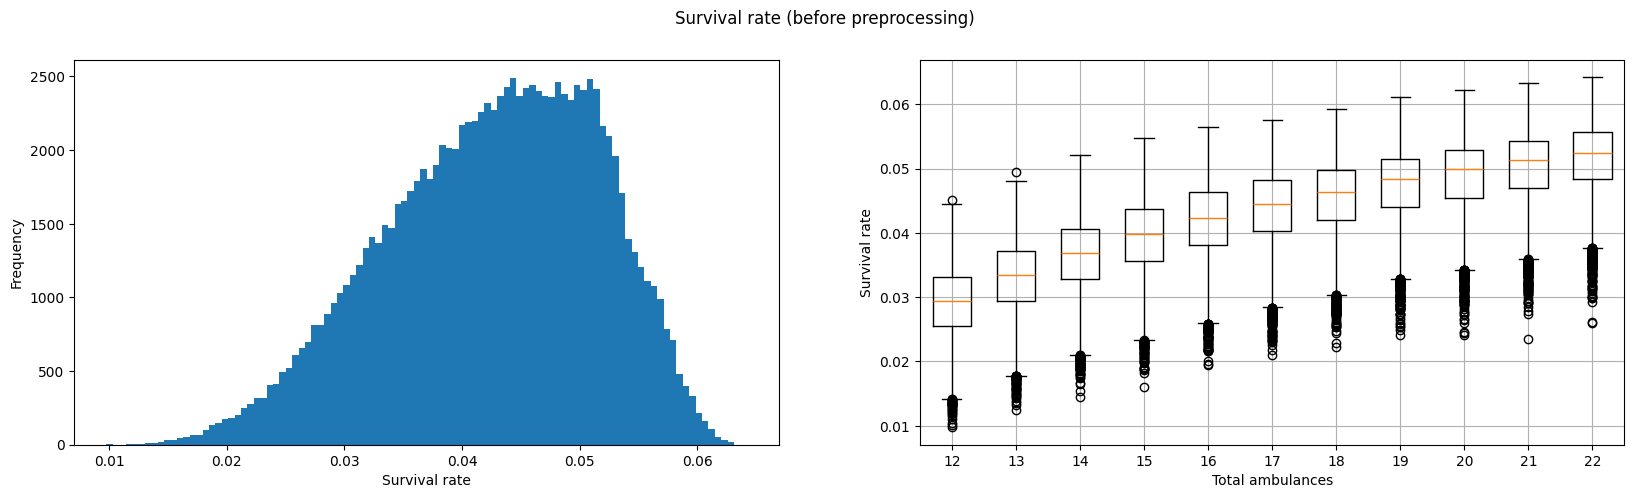

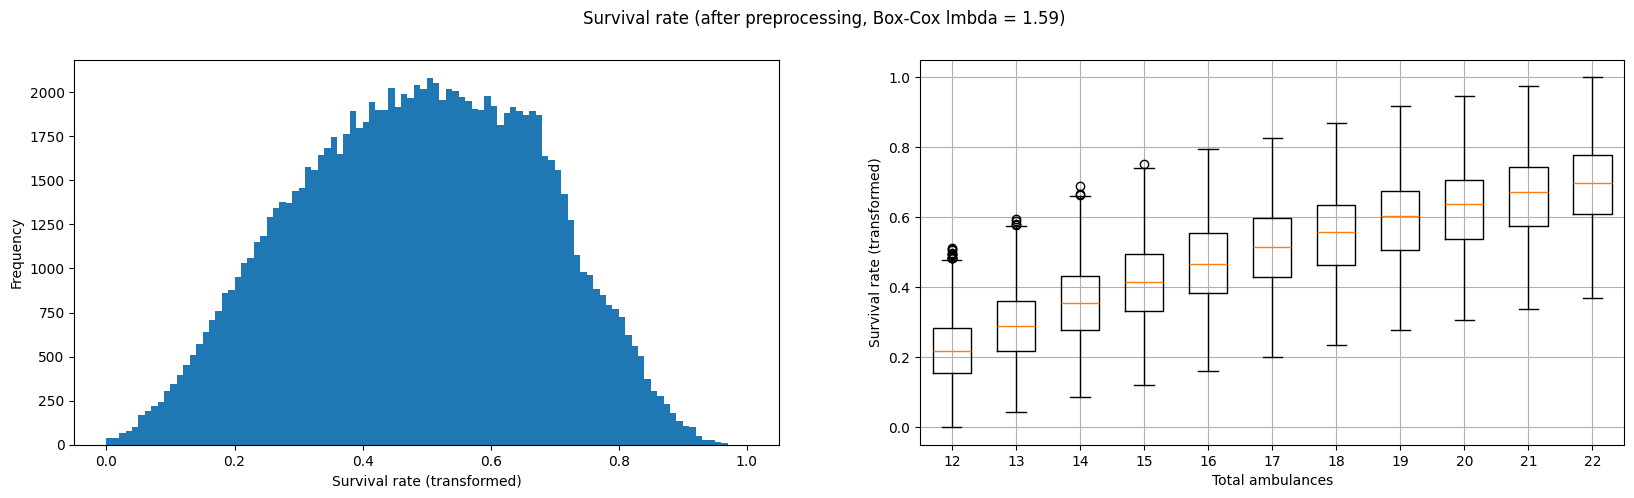

In [10]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.survival_rate.to_numpy()
plot_metric(X, y, "Survival rate (before preprocessing)", "Survival rate")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Survival rate (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Survival rate (transformed)")

In [11]:
X_new = binarize_solutions(X)
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge.fit(X_new, y)
with open('trained_ml_models/simcoe_survival_linear.pkl', 'wb') as f:
    pickle.dump(ridge, f)

In [12]:
with open('trained_ml_models/simcoe_survival_linear.pkl', 'rb') as f:
    ridge = pickle.load(f)
solution, model = linear_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    coef=keep_relevant_coefficients(ridge.coef_, n_stations, FACILITY_CAPACITY),
    intercept=ridge.intercept_,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
(68,) (17, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 53 rows, 69 columns and 239 nonzeros
Model fingerprint: 0x327d865f
Variable types: 1 continuous, 68 integer (68 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 2e+01]
Found heuristic solution: objective -0.6008737
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 52 rows, 68 columns, 170 nonzeros
Variable types: 0 continuous, 68 integer (68 binary)
Found heuristic solution: objective 0.7031112

Root relaxation: objective 8.967899e-01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  D

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.526921,0.798281,0.057724,8.943076,6.645303,17.526444,0.225941,20.588535
1,0.530278,0.808385,0.058493,8.719414,6.541110,17.005631,0.225848,20.679742
2,0.527383,0.806415,0.058671,8.792197,6.601453,17.180528,0.225309,20.580655
3,0.530759,0.809781,0.058178,8.806174,6.536087,17.152094,0.223052,20.483937
4,0.520463,0.803732,0.057748,8.852881,6.739840,17.402930,0.223347,20.453941


In [13]:
model = DecisionTreeRegressor()
grid_search = GridSearchCV(model, {'min_samples_split': [80, 90, 100, 110, 120]}, cv=5)
grid_search.fit(X, y)
dt = grid_search.best_estimator_
with open('trained_ml_models/simcoe_survival_dt.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [14]:
with open('trained_ml_models/simcoe_survival_dt.pkl', 'rb') as f:
    dt = pickle.load(f)
solution, model = dt_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    dt=dt,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8048 rows, 5383 columns and 21475 nonzeros
Model fingerprint: 0x126d5b72
Variable types: 2684 continuous, 2699 integer (2682 binary)
Coefficient statistics:
  Matrix range     [3e-02, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [4e+00, 2e+01]
Found heuristic solution: objective 0.0283070
Presolve removed 1782 rows and 1744 columns
Presolve time: 0.19s
Presolved: 6266 rows, 3639 columns, 34547 nonzeros
Variable types: 0 continuous, 3639 integer (3622 binary)

Root relaxation: objective 9.534430e-01, 1651 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.521762,0.782643,0.058132,9.334861,6.564504,19.470312,0.223201,20.218183
1,0.531456,0.783359,0.058140,9.270679,6.526247,19.473887,0.227007,20.413697
2,0.532381,0.786533,0.058816,9.122964,6.508091,18.571894,0.223485,20.437087
3,0.516781,0.779939,0.056515,9.447247,6.696016,19.566949,0.229796,20.132230
4,0.515429,0.782095,0.057885,9.335100,6.668743,19.371224,0.228438,20.268283


In [9]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='simcoe_survival'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 54%|█████▍    | 54/100 [01:44<01:29,  1.94s/epoch, best_val_loss=0.000136, train_loss=0.000579, val_loss=0.000157]


Early stopping


 91%|█████████ | 91/100 [02:51<00:16,  1.89s/epoch, best_val_loss=4.2e-5, train_loss=4.4e-5, val_loss=4.24e-5]  


Early stopping


100%|██████████| 100/100 [02:48<00:00,  1.68s/epoch, best_val_loss=3.47e-5, train_loss=3.41e-5, val_loss=3.47e-5]


In [15]:
weights, biases = MLP.load_npz('trained_ml_models/simcoe_survival.npz')
solution, model = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4048 rows, 3036 columns and 26082 nonzeros
Model fingerprint: 0x5a1f4747
Variable types: 2019 continuous, 1017 integer (1000 binary)
Coefficient statistics:
  Matrix range     [4e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e-04, 2e+01]
Presolve removed 89 rows and 59 columns
Presolve time: 0.06s
Presolved: 3959 rows, 2977 columns, 26753 nonzeros
Variable types: 1974 continuous, 1003 integer (986 binary)

Root relaxation: objective 3.426274e+00, 1424 iterations, 0.08 seconds (0.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.42627    0  448          -    3.42627  

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.535835,0.828794,0.059176,8.364757,6.493827,16.006330,0.227084,20.626326
1,0.527692,0.823931,0.058761,8.442909,6.614378,16.349944,0.219907,20.757545
2,0.529648,0.820729,0.059055,8.547010,6.608097,16.566809,0.227657,20.557342
3,0.539021,0.832441,0.060273,8.282309,6.461627,16.138765,0.223062,20.669607
4,0.532754,0.821606,0.059114,8.525638,6.577056,16.595536,0.223394,20.617004


# RTMean

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Mean response time (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Mean response time (transformed)'>],
       dtype=object))

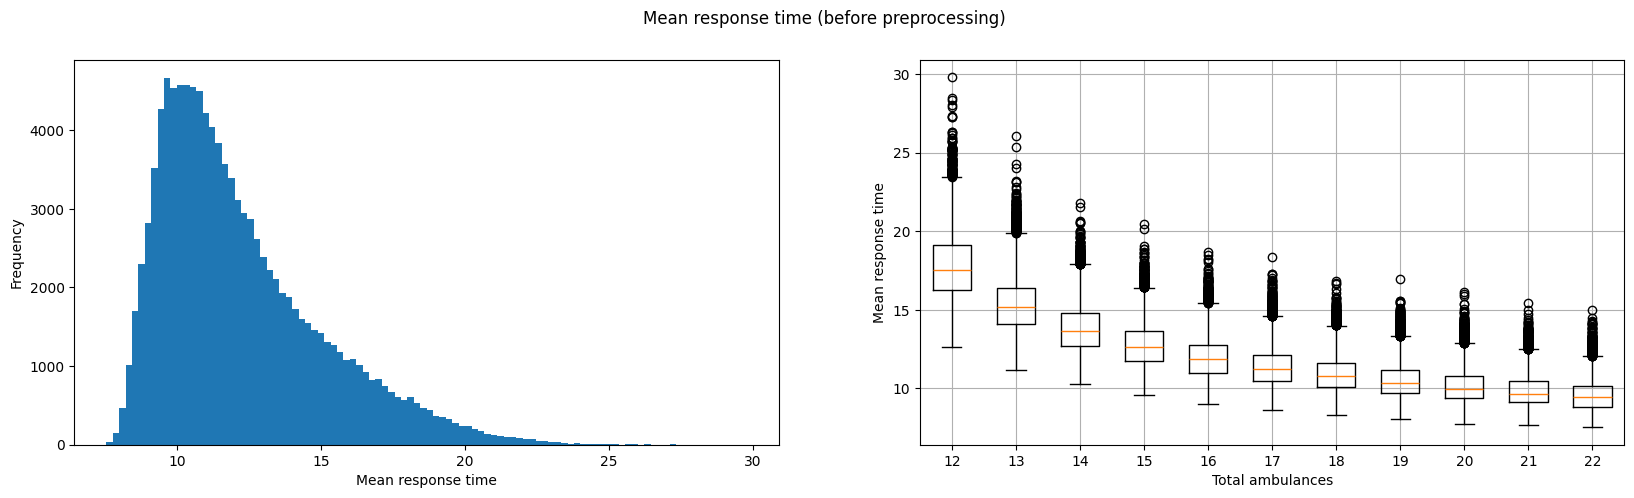

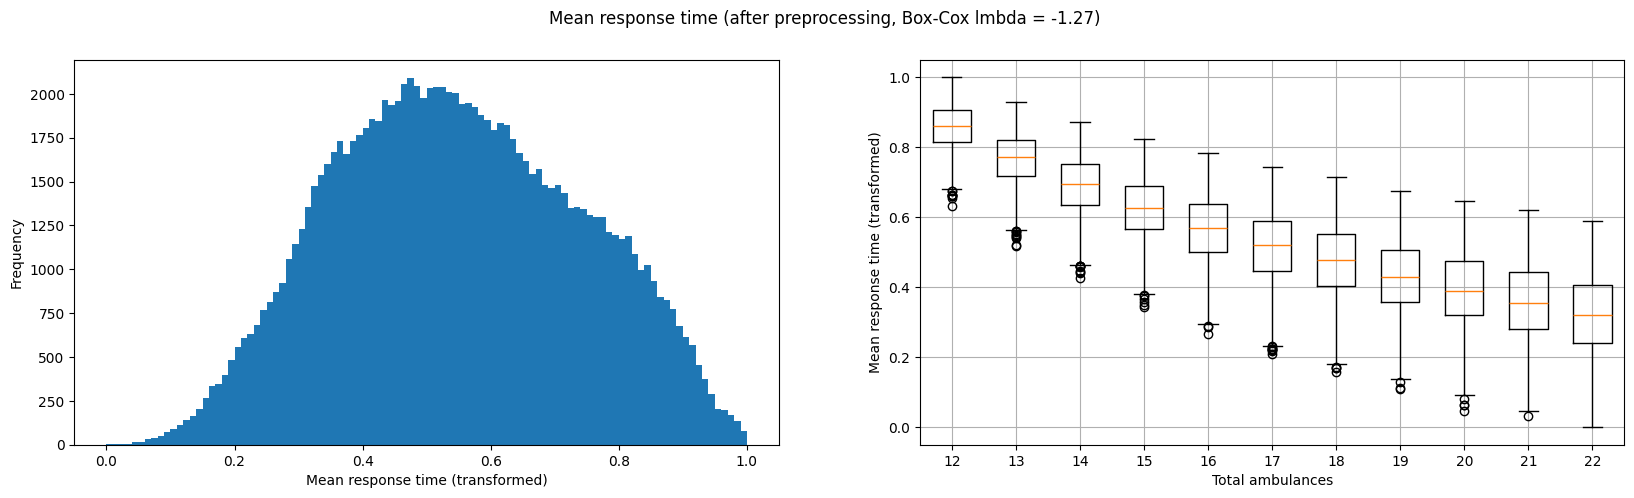

In [16]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.response_time_mean.to_numpy()
plot_metric(X, y, "Mean response time (before preprocessing)", "Mean response time")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Mean response time (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Mean response time (transformed)")

In [17]:
X_new = binarize_solutions(X)
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge.fit(X_new, y)
with open('trained_ml_models/simcoe_median_linear.pkl', 'wb') as f:
    pickle.dump(ridge, f)

In [18]:
with open('trained_ml_models/simcoe_median_linear.pkl', 'rb') as f:
    ridge = pickle.load(f)
solution, model = linear_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    coef=keep_relevant_coefficients(ridge.coef_, n_stations, FACILITY_CAPACITY),
    intercept=ridge.intercept_,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
(68,) (17, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 53 rows, 69 columns and 239 nonzeros
Model fingerprint: 0x6d82790c
Variable types: 1 continuous, 68 integer (68 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+01]
Found heuristic solution: objective 1.7240956
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 52 rows, 68 columns, 170 nonzeros
Variable types: 0 continuous, 68 integer (68 binary)
Found heuristic solution: objective 0.5328991

Root relaxation: objective 1.935494e-01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.488141,0.749291,0.055014,10.138079,7.023195,22.061537,0.234168,19.483800
1,0.481223,0.739660,0.053797,10.443648,7.198887,23.207440,0.238695,19.413481
2,0.483487,0.730031,0.054204,10.509253,7.173841,23.354787,0.237989,19.308256
3,0.482506,0.739902,0.053327,10.410238,7.254238,22.543523,0.237031,19.287036
4,0.493701,0.736226,0.054592,10.383262,7.048935,22.622088,0.239258,19.315675


In [19]:
model = DecisionTreeRegressor()
grid_search = GridSearchCV(model, {'min_samples_split': [80, 90, 100, 110, 120]}, cv=5)
grid_search.fit(X, y)
dt = grid_search.best_estimator_
with open('trained_ml_models/simcoe_median_dt.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [20]:
with open('trained_ml_models/simcoe_median_dt.pkl', 'rb') as f:
    dt = pickle.load(f)
solution, model = dt_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    dt=dt,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8012 rows, 5359 columns and 21379 nonzeros
Model fingerprint: 0xa5b07d7b
Variable types: 2672 continuous, 2687 integer (2670 binary)
Coefficient statistics:
  Matrix range     [6e-02, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [4e+00, 2e+01]
Found heuristic solution: objective 0.9520442
Presolve removed 1762 rows and 1728 columns
Presolve time: 0.17s
Presolved: 6250 rows, 3631 columns, 34439 nonzeros
Variable types: 0 continuous, 3631 integer (3614 binary)
Found heuristic solution: objective 0.9406228

Root relaxation: objective 5.800450e-02, 947 iterations, 0.06 seconds (0.14 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.473577,0.738065,0.052756,10.207142,7.320461,21.338612,0.270319,19.312048
1,0.478840,0.737787,0.052760,10.287275,7.265600,21.375823,0.275120,19.284851
2,0.477520,0.747664,0.052967,10.233969,7.299343,21.384533,0.271780,19.412244
3,0.491732,0.758967,0.054207,10.054882,7.063297,21.009754,0.266949,19.624103
4,0.464313,0.734005,0.051921,10.438268,7.428460,21.975129,0.270685,19.310673


In [13]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='simcoe_median'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 69%|██████▉   | 69/100 [02:07<00:57,  1.85s/epoch, best_val_loss=0.000153, train_loss=0.000674, val_loss=0.000184]


Early stopping


 63%|██████▎   | 63/100 [01:58<01:09,  1.88s/epoch, best_val_loss=4.75e-5, train_loss=4.95e-5, val_loss=5.62e-5]


Early stopping


100%|██████████| 100/100 [02:45<00:00,  1.66s/epoch, best_val_loss=3.44e-5, train_loss=3.43e-5, val_loss=3.44e-5]


In [21]:
weights, biases = MLP.load_npz('trained_ml_models/simcoe_median.npz')
solution, model = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4028 rows, 3036 columns and 26062 nonzeros
Model fingerprint: 0xad7f200d
Variable types: 2019 continuous, 1017 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e-06, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e-04, 2e+01]
Found heuristic solution: objective 1.4454781
Presolve removed 39 rows and 29 columns
Presolve time: 0.05s
Presolved: 3989 rows, 3007 columns, 25630 nonzeros
Variable types: 1994 continuous, 1013 integer (996 binary)

Root relaxation: objective -3.489887e+00, 1862 iterations, 0.15 seconds (0.35 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.544908,0.835210,0.059865,8.328466,6.449719,15.986498,0.222918,20.619559
1,0.554503,0.839216,0.061123,8.150003,6.320948,15.740494,0.220284,20.565363
2,0.547033,0.838489,0.060449,8.163814,6.411003,15.604194,0.222925,20.809943
3,0.539081,0.835872,0.060183,8.277694,6.480013,15.858779,0.226336,20.644358
4,0.546899,0.830103,0.059963,8.314747,6.366803,16.016225,0.219708,20.714834
